## Anomaly Detection Project - UST Assessment

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## DATA

In [3]:
# Importing data
data = pd.read_csv("log2.csv")

In [5]:
# Data dimensions
print("Rows:", data.shape[0])
print("Columns:", data.shape[1])

Rows: 65532
Columns: 12


In [7]:
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


### Step 1 - EXPLORATORY DATA ANALYSIS (Light EDA before train/test split)

In [9]:
# Checking the type of data column and missing values in each
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


##### Thus, the data provided has no missing values in any of the columns.

In [39]:
# Numerical Features
num_features = data.iloc[:, 5:12]
num_features.head()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,177,94,83,2,30,1,1
1,4768,1600,3168,19,17,10,9
2,238,118,120,2,1199,1,1
3,3327,1438,1889,15,17,8,7
4,25358,6778,18580,31,16,13,18


In [13]:
# Statistical summary of the numerical features
num_desc = num_features.describe()
num_desc.applymap(lambda x: f'{x:.2f}')

/var/folders/kb/v5w5dyyj6rz2jrrv1jwjyjwr0000gn/T/ipykernel_15927/3143618839.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_desc.applymap(lambda x: f'{x:.2f}')


,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.00,65532.00,65532.00,65532.00,65532.00,65532.00,65532.00
mean,97123.95,22385.80,74738.15,102.87,65.83,41.40,61.47
std,5618438.91,3828138.65,2463207.71,5133.00,302.46,3218.87,2223.33
min,60.00,60.00,0.00,1.00,0.00,1.00,0.00
25%,66.00,66.00,0.00,1.00,0.00,1.00,0.00
50%,168.00,90.00,79.00,2.00,15.00,1.00,1.00
75%,752.25,210.00,449.00,6.00,30.00,3.00,2.00
max,1269359015.00,948477220.00,320881795.00,1036116.00,10824.00,747520.00,327208.00


##### Looking at the summary and comparing the IQR and the maximum values in each column, we can clearly see that there are outliers in almost every numerical feature. Transforming the features before visualising might help to see patterns more clearly. Hence, I will be log transforming the features before plotting.

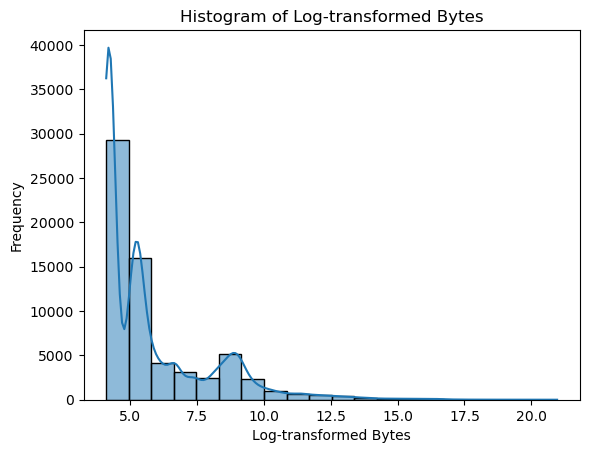

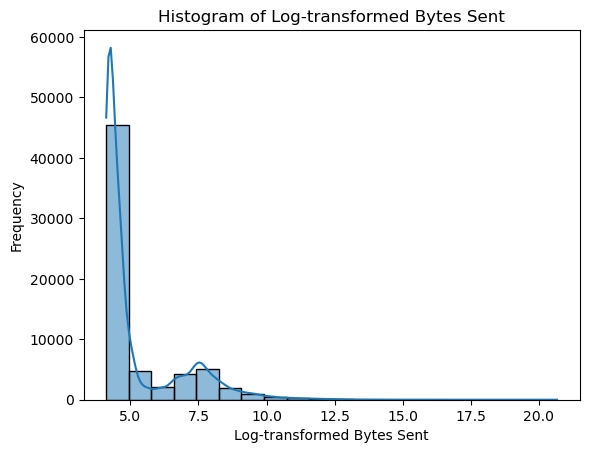

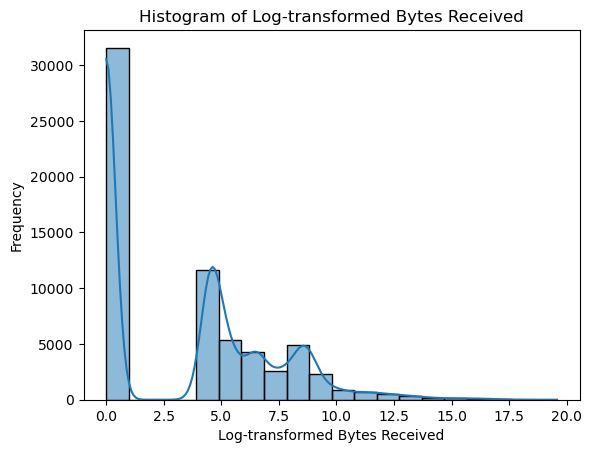

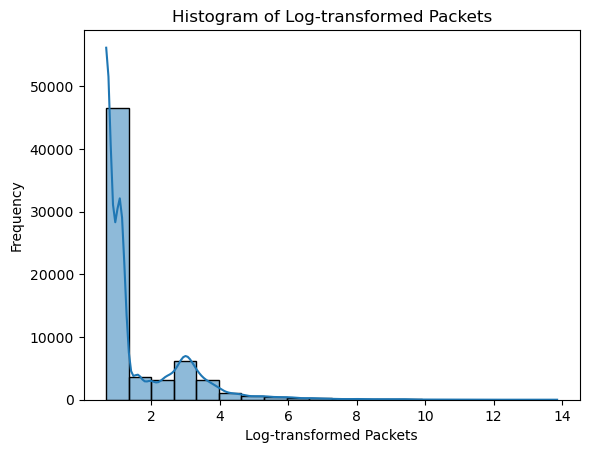

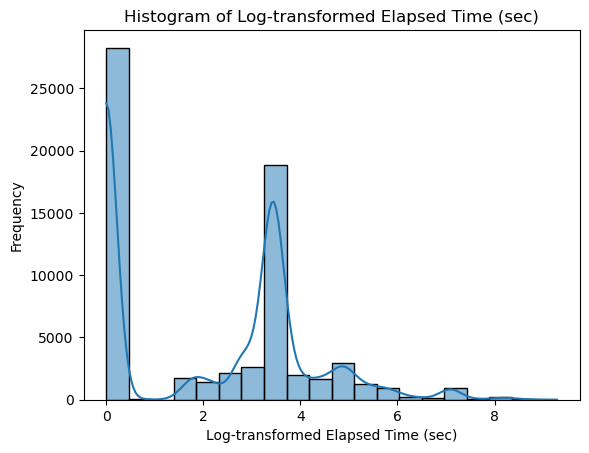

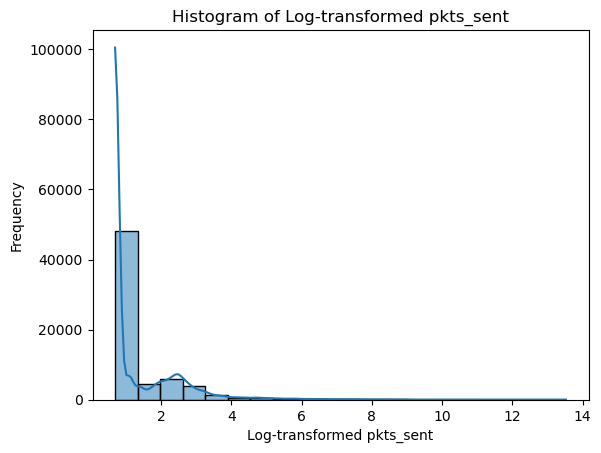

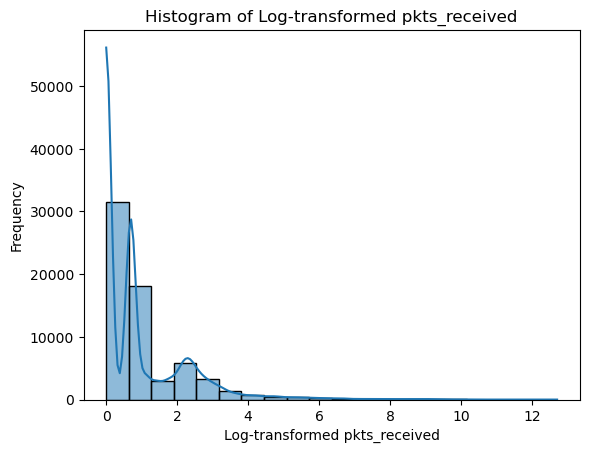

In [47]:
for num_feature in num_features:
    sns.histplot(np.log1p(data[num_feature]),bins = 20, kde = True) # log1p as some data values are 0.
    plt.title(f"Histogram of Log-transformed {num_feature}")
    plt.xlabel(f"Log-transformed {num_feature}")
    plt.ylabel("Frequency")
    plt.show()

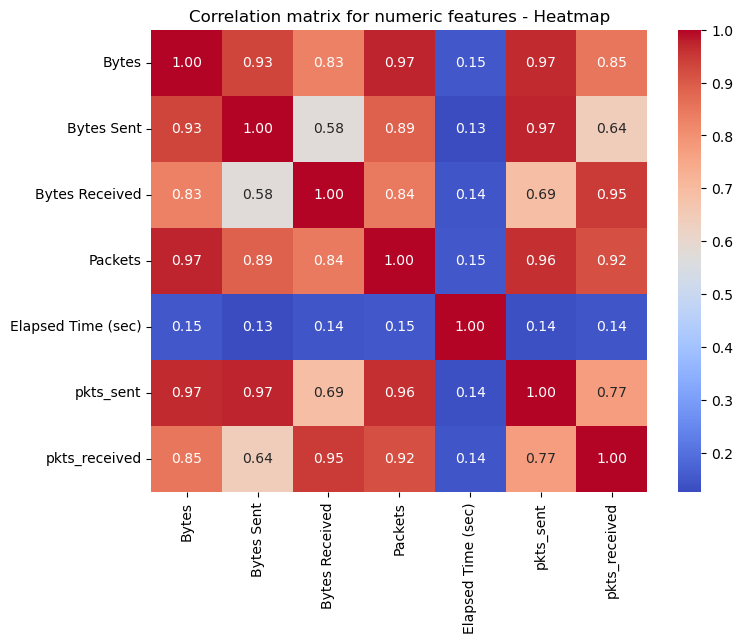

In [15]:
# Checking correlation between numerical features (all variables)
corr_num = num_features.corr()

plt.figure(figsize = (8,6))
sns.heatmap(corr_num, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title("Correlation matrix for numeric features - Heatmap")
plt.show()

##### The variable bytes is equivalent to the sum total of bytes sent and bytes received, which guarentees a perfect or nearly perfect correlation between bytes and both bytes sent/bytes received. This is similar for the variable packets. It would be better to check for multicollinearity by including either the components or the totals for both these variable types.

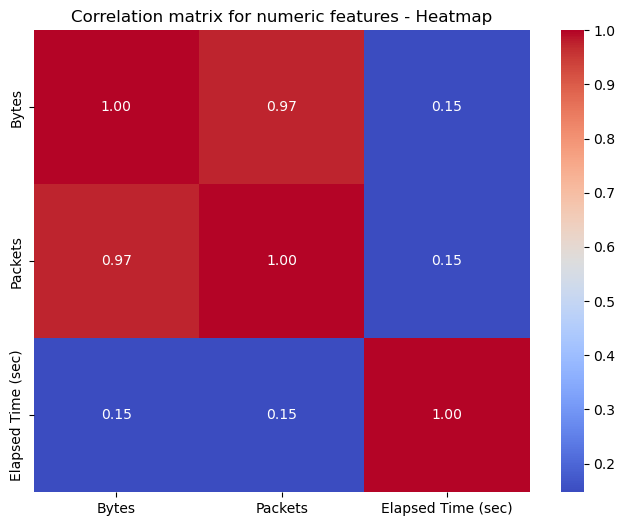

In [17]:
# Checking correlation between numerical features (all variables)
num_features2 = num_features[['Bytes', 'Packets', 'Elapsed Time (sec)']]
corr_num2 = num_features2.corr()

plt.figure(figsize = (8,6))
sns.heatmap(corr_num2, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title("Correlation matrix for numeric features - Heatmap")
plt.show()

##### Here we can see that the bytes and packets variables are highly correlated to each other. The variable for time elapsed does not seem to be correlated to any of the two variables. We can check for feature importance and try to improve the model fit by using either of the bytes or packets variable as well. 

In [9]:
# Categorical features
cat_features = data.iloc[:,0:4]
cat_features.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port
0,57222,53,54587,53
1,56258,3389,56258,3389
2,6881,50321,43265,50321
3,50553,3389,50553,3389
4,50002,443,45848,443


In [17]:
# Top 10 values for each categorical variable
port_value_counts = {col:cat_features[col].value_counts().head(10) for col in cat_features}
port_value_counts

{'Source Port': Source Port
 58638    840
 27005    513
 443      273
 57470    222
 49418    210
 6881     177
 0        173
 50584    116
 3478     105
 26900    102
 Name: count, dtype: int64,
 'Destination Port': Destination Port
 53       15414
 445      12891
 443      11684
 80        4035
 25174     1087
 5900       909
 37965      826
 22114      767
 64147      756
 50584      717
 Name: count, dtype: int64,
 'NAT Source Port': NAT Source Port
 0        28432
 48817       83
 58638       51
 50116       15
 7986         5
 30399        5
 43757        5
 57880        5
 57596        5
 60868        5
 Name: count, dtype: int64,
 'NAT Destination Port': NAT Destination Port
 0        28432
 53       15094
 443      11678
 80        4028
 27015      234
 27017      160
 123        156
 3389       156
 6881       143
 5228       100
 Name: count, dtype: int64}

<function matplotlib.pyplot.show(close=None, block=None)>

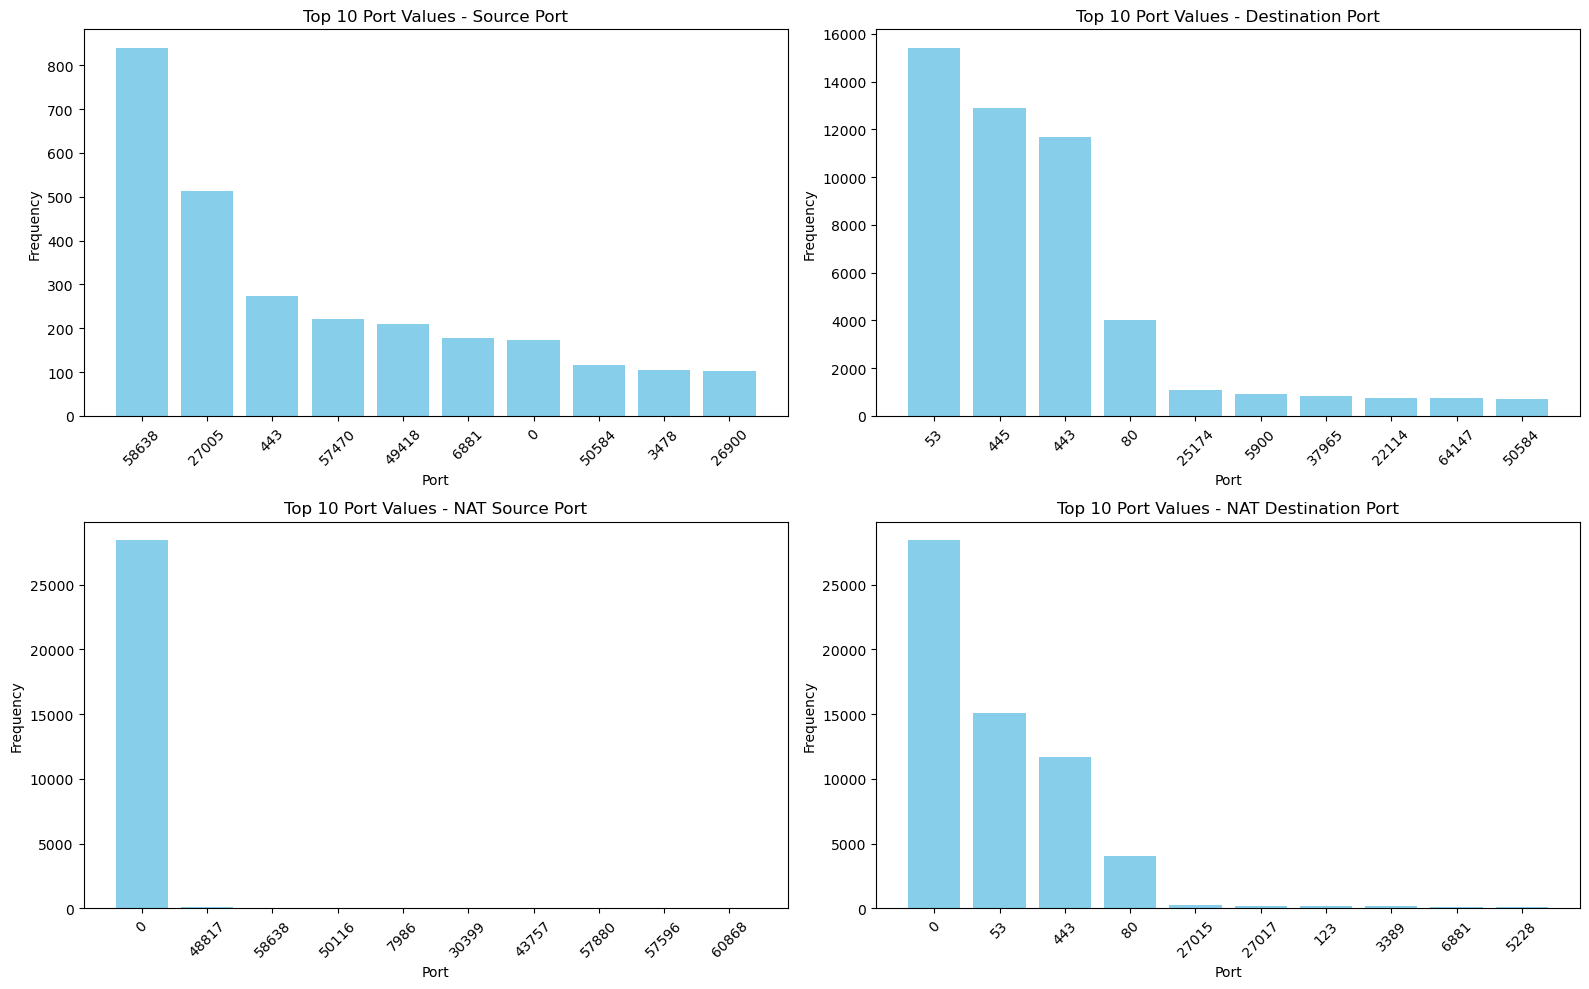

In [21]:
# Plotting these top 10 values
fig, axes = plt.subplots(2,2, figsize = (16,10))
axes = axes.flatten()

for i, (col, counts) in enumerate(port_value_counts.items()):
    axes[i].bar(counts.index.astype(str), counts.values, color='skyblue')
    axes[i].set_title(f"Top 10 Port Values - {col}")
    axes[i].set_xlabel("Port")
    axes[i].set_ylabel("Frequency")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show

#### There is one column left in the data to analyse, the 'Action' column. This column tells us what decision was made by a network security device in response to the traffic flow or connection attempt. So, if the Action column has a value - allow, the traffic was permitted and if the value is deny, then it was blocked. But can we surely say that the traffic which was blocked by the network security was actually malicious or suspicious? We need to validate this with some quick analysis first

In [47]:
summary_numeric = data.groupby('Action')[data.columns[5:13]].mean()
summary_numeric

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
Action,,,,,,,
allow,169037.953241,38917.411743,130120.541498,178.348565,114.617349,71.334883,107.013682
deny,83.211717,83.036098,0.175619,1.003270,0.000133,1.002202,0.001068
drop,68.675278,68.675278,0.000000,1.000000,0.000000,1.000000,0.000000
reset-both,157.351852,141.796296,15.555556,1.666667,0.129630,1.444444,0.222222


#### From the table we can see :
- Denied, dropped or reset traffic is extremely minimal. Only 1 packet, minimal data exchange and nearly zero duration.
- Allowed traffic is dramatically different with high bytes transferred, many packets and long session durations.

Thus, we can use 'Action' as a target variable here to fit a supervised machine learning model.

<Axes: xlabel='Action', ylabel='count'>

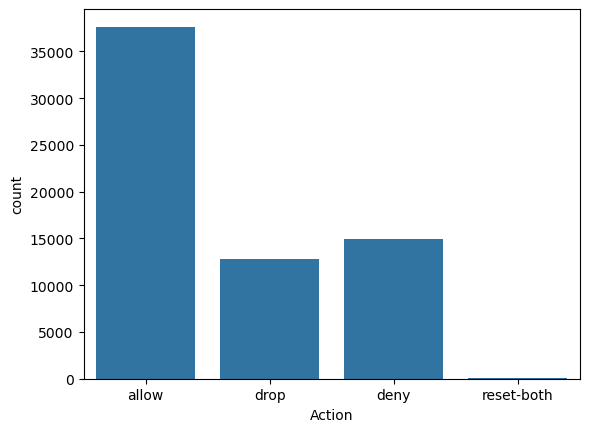

In [85]:
sns.countplot(x = 'Action', data = data)

#### The problem involves detecting threats or blocked traffic, hence it makes sense to group together deny, drop and reset-both as they all indicate that the system rejected or blocked a connection. This would help make the model training easier, evaluation more meaningful and results more interpretable.

In [5]:
data['Original_Action'] = data['Action']

In [11]:
data['Action'] = data['Action'].apply(lambda x: 0 if x=='allow' else 1)

In [13]:
data['Action'].value_counts()

Action
0    37640
1    27892
Name: count, dtype: int64

### Step 2 - Train/Test Split

In [15]:
from sklearn.model_selection import train_test_split

X = data.drop(['Action', 'Original_Action'], axis = 1)
Y = data['Action']

In [17]:
X.shape, Y.shape

((65532, 11), (65532,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [21]:
X_train.shape, y_train.shape

((45872, 11), (45872,))

### Step 3 - Deeper EDA (using train data set only)

#### This stage will involve looking at the relationship of the target variable with all the other features in the data

/var/folders/kb/v5w5dyyj6rz2jrrv1jwjyjwr0000gn/T/ipykernel_60393/2967736370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Action'] = y_train


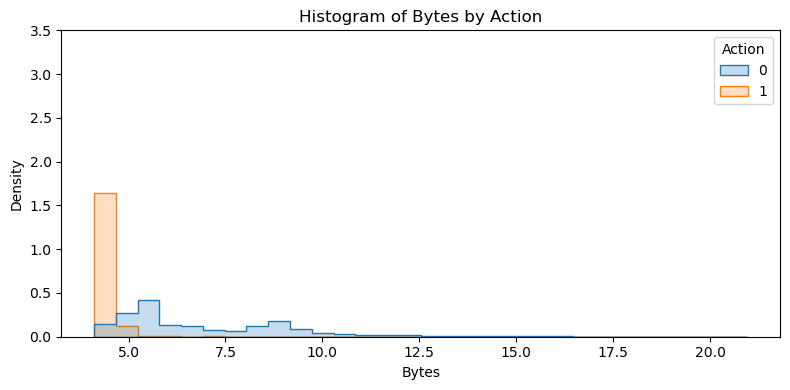

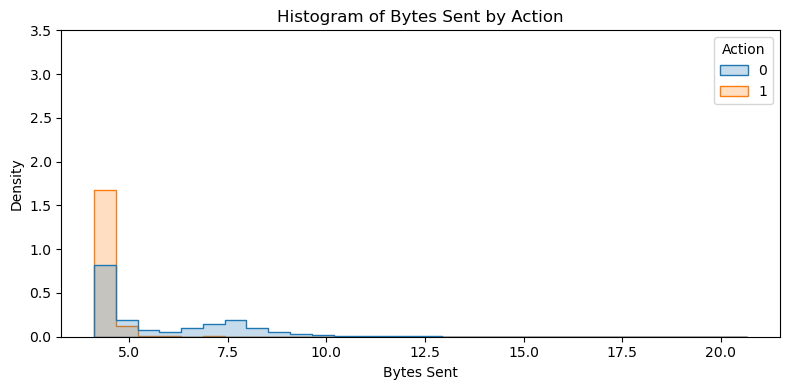

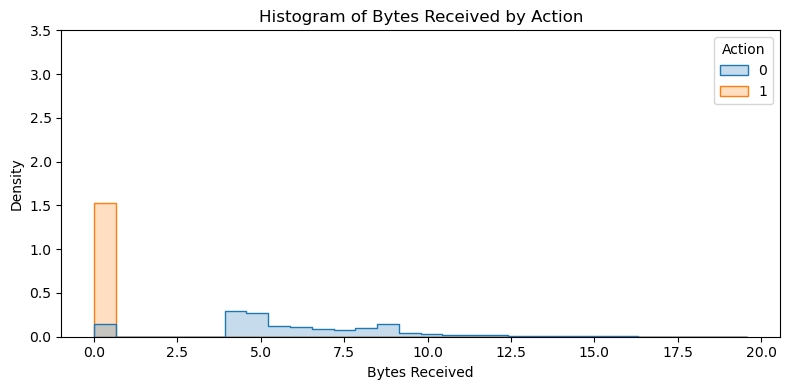

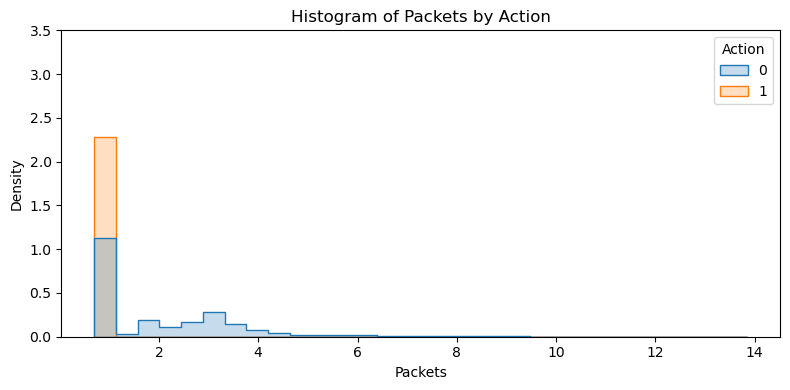

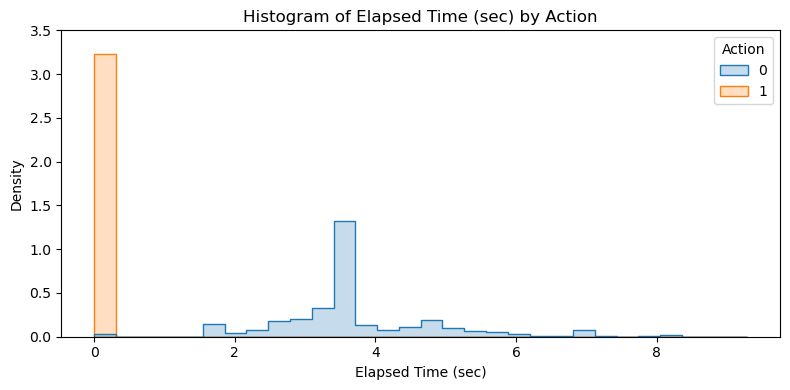

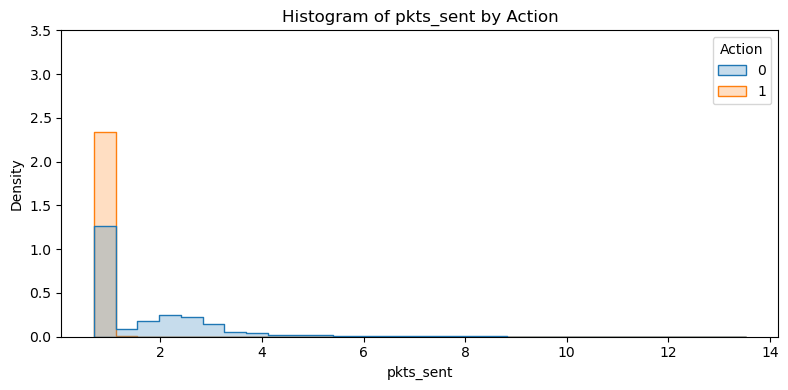

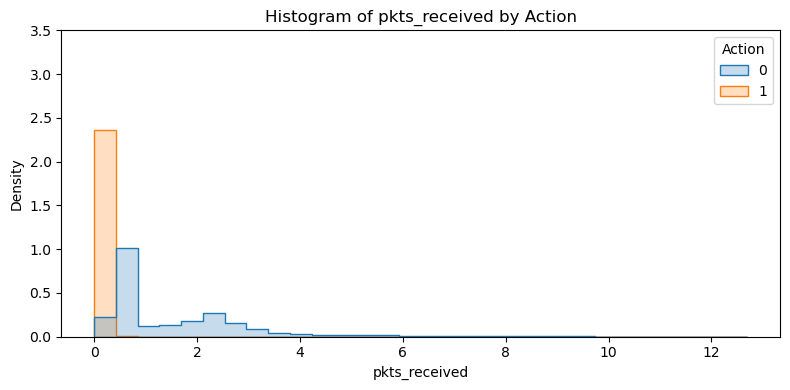

In [143]:
# Relationship of target variable with numerical variables

train_data = X_train.iloc[:, 4:11]
train_data['Action'] = y_train

for col in train_data.columns:
    if col == 'Action':
        continue
    plt.figure(figsize = (8,4))
    sns.histplot(data = train_data, x = np.log1p(train_data[col]), hue = 'Action', kde = False, bins = 30, element = 'step', stat = 'density', common_norm = False)
    plt.title(f"Histogram of {col} by Action")
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.ylim(0, 3.5)
    plt.tight_layout()
    plt.show()

/var/folders/kb/v5w5dyyj6rz2jrrv1jwjyjwr0000gn/T/ipykernel_60393/243675598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Action'] = y_train


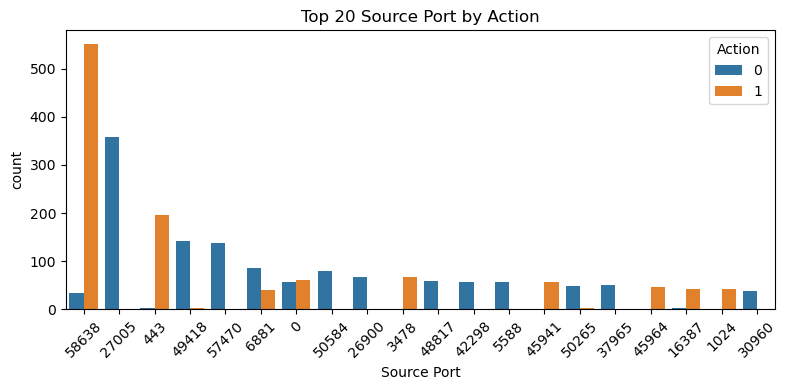

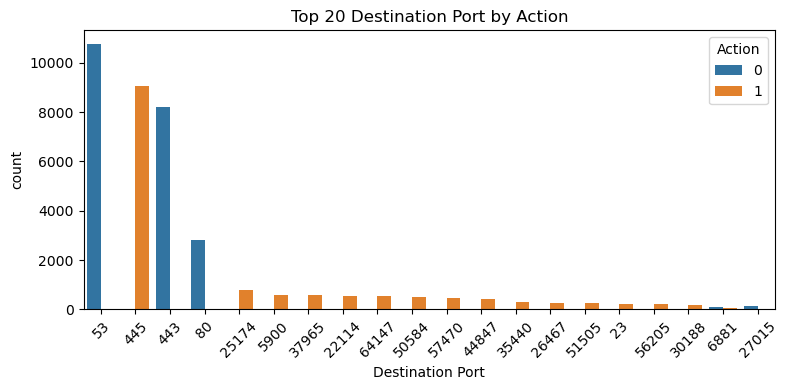

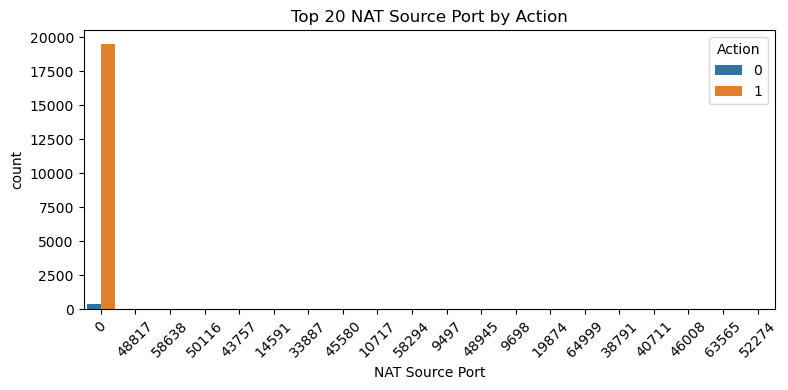

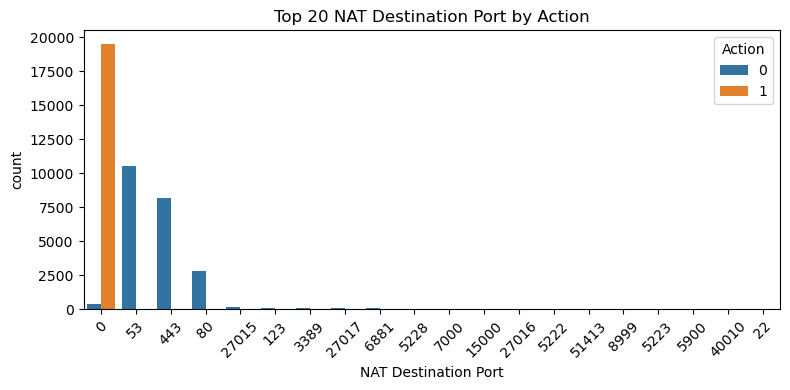

In [154]:
# Relationship of target variables with categorical variables
train_data = X_train.iloc[:,0:4]
train_data['Action'] = y_train

for col in train_data.columns:
    if col == 'Action':
        continue
    plt.figure(figsize = (8,4))
    sns.countplot(data = train_data, x= col, hue = 'Action', order = train_data[col].value_counts().index[:20])
    plt.title(f"Top 20 {col} by Action")
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

In [156]:
y_train.value_counts()

Action
0    26310
1    19562
Name: count, dtype: int64

#### There does not seem to be any class imbalance, so the target variable can be used as is.

### Step 4 - Supervised Modelling

In [23]:
# Creating a function to return all the evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score

def metric_func(test_data, pred_data, proba_data):
    """
    Prints key classification metrics and confusion matrix.
    Parameters:
    - test_data: Ground truth labels (y_test)
    - pred_data: Predicted labels (y_pred)
    - proba_data: Predicted probabilities for the positive class (y_proba)
    """
    # Compute metrics
    accuracy = accuracy_score(test_data, pred_data)
    precision = precision_score(test_data, pred_data)
    recall = recall_score(test_data, pred_data)
    f1score = f1_score(test_data, pred_data)
    auc_score = roc_auc_score(test_data, proba_data)
    con_matrix = confusion_matrix(test_data, pred_data)

    print("Model Performance Metrics:")
    print(f"- Accuracy: {accuracy:.4f}")
    print(f"- Precision: {precision:.4f}")
    print(f"- F1 Score: {f1score:.4f}")
    print(f"- Recall: {recall:.4f}")
    print(f"- AUC-ROC Score: {auc_score:.4f}")

    plt.figure(figsize = (5,4))
    sns.heatmap(con_matrix, annot = True, cmap= 'Blues', fmt = 'd')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [48]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight = "balanced", random_state = 42)
rf_model.fit(X_train, y_train)

y_rf_pred = rf_model.predict(X_test)
y_rf_prob = rf_model.predict_proba(X_test)[:, 1]

Model Performance Metrics:
- Accuracy: 0.9998
- Precision: 0.9995
- F1 Score: 0.9998
- Recall: 1.0000
- AUC-ROC Score: 1.0000


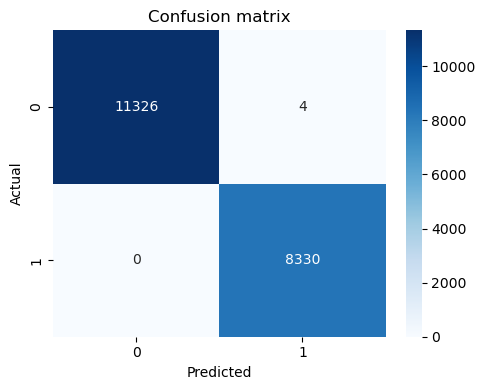

In [46]:
# Basic Metrics
rf_results = metric_func(y_test, y_rf_pred, y_rf_prob)

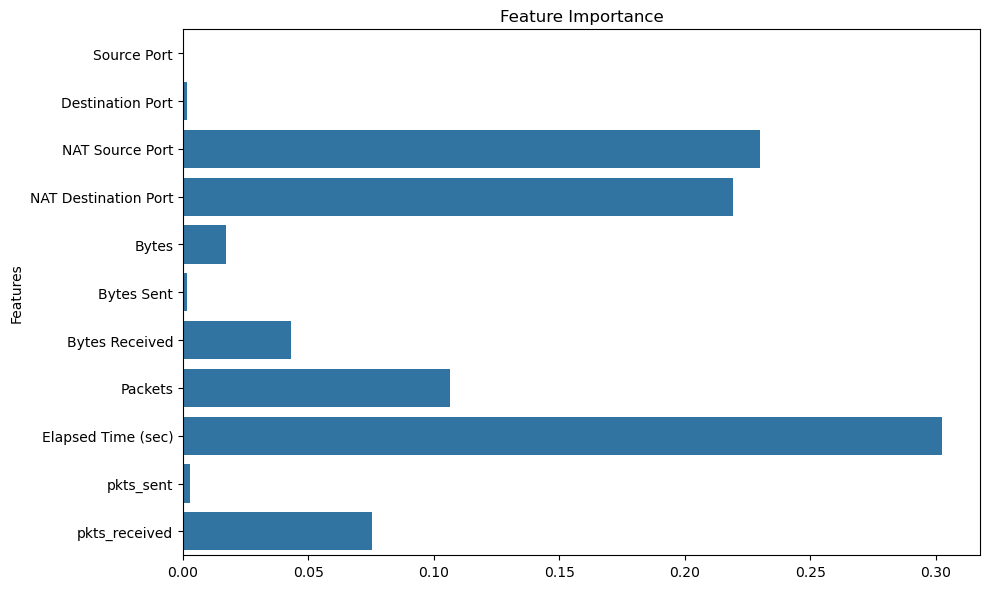

In [49]:
# Feature importance
feat_importance = rf_model.feature_importances_
features = X_train.columns

plt.figure(figsize = (10,6))
sns.barplot(x = feat_importance, y = features)
plt.title("Feature Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [51]:
# Gradient Boosting model
!pip install xgboost
from xgboost import XGBClassifier
gb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
gb_model.fit(X_train, y_train)

y_gb_pred = gb_model.predict(X_test)
y_gb_proba = gb_model.predict_proba(X_test)[:,1]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:47:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Performance Metrics:
- Accuracy: 0.9997
- Precision: 0.9994
- F1 Score: 0.9997
- Recall: 1.0000
- AUC-ROC Score: 1.0000


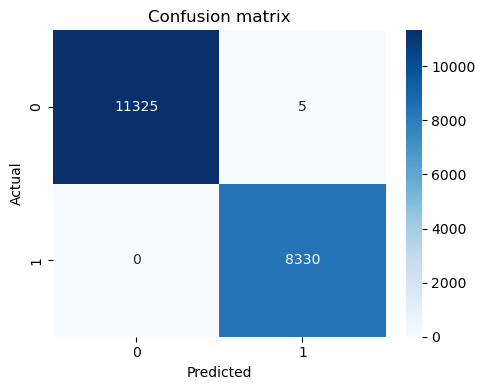

In [53]:
gb_results = metric_func(y_test, y_gb_pred, y_gb_proba)

### Step 5 - Unsupervised Modelling

In [25]:
y_train.value_counts(normalize = True)

Action
0    0.573552
1    0.426448
Name: proportion, dtype: float64

In [27]:
# Isolation Forest
from sklearn.ensemble import IsolationForest

isf_model = IsolationForest(n_estimators = 100, contamination = 0.42, random_state = 42)
isf_model.fit(X_train)

isf_pred = isf_model.predict(X_test)

isf_test_preds = [1 if x == -1 else 0 for x in isf_pred]

In [29]:
print(f"Anomalies detected: {np.sum(isf_test_preds)}")

Anomalies detected: 8260


In [81]:
confusion_matrix(y_test, isf_test_preds)

array([[4993, 6337],
       [6407, 1923]])

In [85]:
accuracy_score(y_test, isf_test_preds)

0.35178026449643945

In [54]:
results_isf = X_test.copy()
results_isf['Original_Action'] = data.loc[X_test.index, 'Original_Action']

In [56]:
results_isf['Predicted_Anomaly'] = isf_test_preds

In [58]:
results_isf[results_isf['Predicted_Anomaly'] == 1]['Original_Action'].value_counts()

Original_Action
allow         6337
deny          1913
reset-both      10
Name: count, dtype: int64

In [44]:
# Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor
lof_model = LocalOutlierFactor(n_neighbors = 20, contamination = 0.42)

lof_pred = lof_model.fit_predict(X_test)
lof_test_preds = [1 if x == -1 else 0 for x in lof_pred]

In [50]:
accuracy_score(y_test, lof_test_preds)

0.4186673448626653

### Step 6 - Combining Results from Supervised and Unsupervised Modelling

In [68]:
# Combining results from both supervised and unsupervised models

results_df = results_isf.copy()

results_df.rename(columns = {'Predicted_Anomaly': 'Unsupervised_Prediction'}, inplace = True)
results_df['Supervised_Prediction'] = y_rf_pred

In [76]:
results_df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Original_Action,Unsupervised_Prediction,Supervised_Prediction
43957,51313,64147,0,0,66,66,0,1,0,1,0,deny,1,1
4530,49949,443,7206,443,4712,908,3804,18,89,9,9,allow,1,0
6666,64070,53,27144,53,258,110,148,2,30,1,1,allow,0,0
25400,61279,445,0,0,66,66,0,1,0,1,0,drop,0,1
36054,51983,443,27301,443,23955,4211,19744,42,46,21,21,allow,1,0


In [78]:
# Creating a combined risk score
def risk_score(row):
    if row['Supervised_Prediction'] == 1 and row['Unsupervised_Prediction'] == 1:
        return 'High Risk'
    elif row['Supervised_Prediction'] == 1:
        return 'Known Attack'
    elif row['Unsupervised_Prediction'] == 1:
        return 'Potential Threat'
    else:
        return 'Normal'

results_df['Risk_label'] = results_df.apply(risk_score, axis = 1)

In [80]:
results_df['Risk_label'].value_counts()

Risk_label
Known Attack        6407
Potential Threat    6333
Normal              4993
High Risk           1927
Name: count, dtype: int64

Text(0.5, 1.0, 'Combined Risk Assessment by the variable Action')

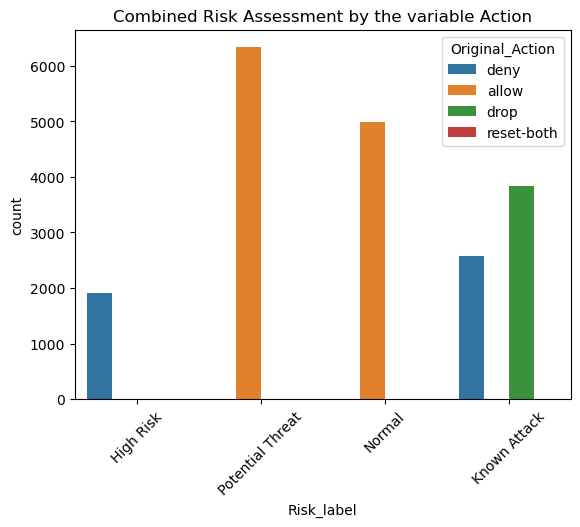

In [88]:
# Visualising the risk score
sns.countplot(data = results_df, x='Risk_label',hue = 'Original_Action')
plt.xticks(rotation = 45)
plt.title('Combined Risk Assessment by the variable Action')

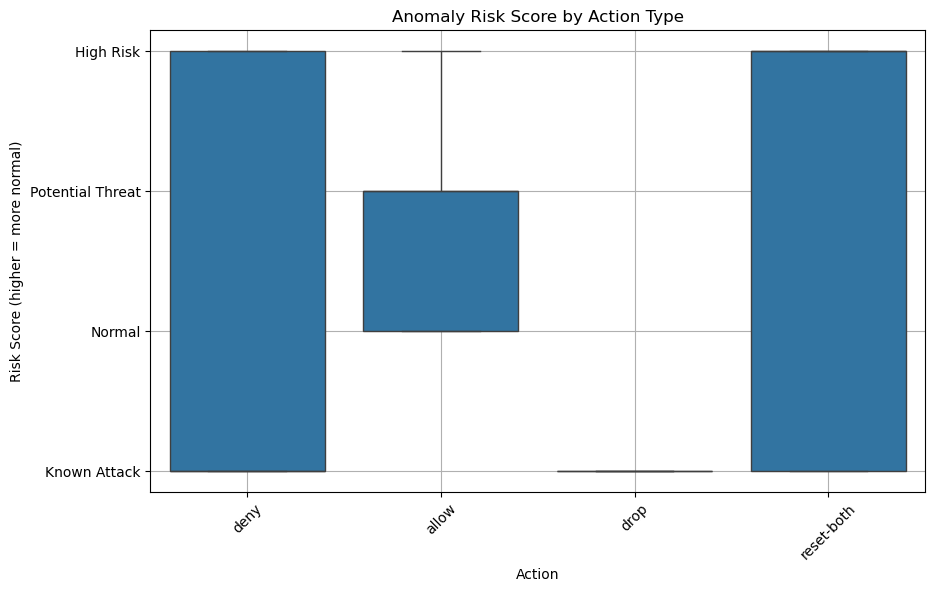

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Original_Action', y='Risk_label', data=results_df)
plt.title('Anomaly Risk Score by Action Type')
plt.ylabel('Risk Score (higher = more normal)')
plt.xlabel('Action')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [109]:
# Saving the final data with result 

results_df.to_csv('Finaldata_with_Modelresults.csv', index = False)